In [68]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/zb-da1-competition/Special_Sale_Calendar.csv
/kaggle/input/zb-da1-competition/ConsumerElectronics.csv
/kaggle/input/zb-da1-competition/NPS_Stockindex.csv
/kaggle/input/zb-da1-competition/Media Investment.csv


## 프로젝트 내용


### 1. 문제정의

--------------------------------
* NPS점수가 대폭 하락후 상승추세이긴 하지만, 전체 데이터 기간에서 봤을때 하락추세임을 확인 </br>
* A사의 E-commerce사업이 잘되기 위해선 우선 소비자 만족도를 높여야 한다는 판단 </br>
* NPS점수와 고객수(주문건수)가 반비례하다는것을 확인
---------------------------------

### 2. 기대효과

--------------------------------
* A사의 E-commerce 서비스 만족도 상승
--------------------------------

### 3. 해결방법

---------------------------------
* 데이터 기간동안의 NPS점수를 분석하여 증가와 하락의 이유를 분석</br>


## 1. Data Read & Preprocessing


In [69]:
# ▶ Warnings 제거
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
df1 = pd.read_csv('/kaggle/input/zb-da1-competition/Special_Sale_Calendar.csv')
df2 = pd.read_csv('/kaggle/input/zb-da1-competition/ConsumerElectronics.csv')
df3 = pd.read_csv('/kaggle/input/zb-da1-competition/NPS_Stockindex.csv')
df4 = pd.read_csv('/kaggle/input/zb-da1-competition/Media Investment.csv')

df2.head()
# 지수 표기법으로 표현된 숫자는 변환이 필요해보임...-> 근데 굳이 이럴필요가 있을까...?

,fsn_id,order_date,Year,Month,order_id,order_item_id,gmv,units,deliverybdays,deliverycdays,s1_fact.order_payment_type,sla,cust_id,pincode,product_analytic_super_category,product_analytic_category,product_analytic_sub_category,product_analytic_vertical,product_mrp,product_procurement_sla
0,ACCCX3S58G7B5F6P,2015-10-17 15:11:54,2015,10,3.419301e+15,3.419301e+15,6400,1,\N,\N,COD,5,-1.01299130778588E+018,-7.79175582905735E+018,CE,CameraAccessory,CameraAccessory,CameraTripod,7190,0
1,ACCCX3S58G7B5F6P,2015-10-19 10:07:22,2015,10,1.420831e+15,1.420831e+15,6900,1,\N,\N,COD,7,-8.99032457905512E+018,7.33541149097431E+018,CE,CameraAccessory,CameraAccessory,CameraTripod,7190,0
2,ACCCX3S5AHMF55FV,2015-10-20 15:45:56,2015,10,2.421913e+15,2.421913e+15,1990,1,\N,\N,COD,10,-1.0404429420466E+018,-7.47768776228657E+018,CE,CameraAccessory,CameraAccessory,CameraTripod,2099,3
3,ACCCX3S5AHMF55FV,2015-10-14 12:05:15,2015,10,4.416592e+15,4.416592e+15,1690,1,\N,\N,Prepaid,4,-7.60496084352714E+018,-5.83593163877661E+018,CE,CameraAccessory,CameraAccessory,CameraTripod,2099,3
4,ACCCX3S5AHMF55FV,2015-10-17 21:25:03,2015,10,4.419525e+15,4.419525e+15,1618,1,\N,\N,Prepaid,6,2.8945572083453E+018,5.34735360997242E+017,CE,CameraAccessory,CameraAccessory,CameraTripod,2099,3


In [70]:
# 투자비용이 줄어들면 고객수도 줄어든다
monthly_cust_cnt = df2.groupby(['Year','Month'])['cust_id'].count()
monthly_cust_cnt

Year  Month
2015  5             1
      6             6
      7         88683
      8           271
      9        209202
      10       207301
      11       130203
      12       158151
2016  1        143768
      2        144084
      3        153299
      4        134390
      5        157071
      6        121792
      7           602
Name: cust_id, dtype: int64

In [72]:
monthly_invest = df4.groupby(['Year','Month'])['Total Investment'].sum().reset_index()
monthly_invest


,Year,Month,Total Investment
0,2015,7,17.1
1,2015,8,5.1
2,2015,9,96.3
3,2015,10,170.2
4,2015,11,51.2
5,2015,12,106.7
6,2016,1,74.2
7,2016,2,48.1
8,2016,3,100.0
9,2016,4,56.8


In [73]:
monthly_merged_df = pd.merge(monthly_cust_cnt, monthly_invest, on=['Year', 'Month'])
monthly_merged_df

,Year,Month,cust_id,Total Investment
0,2015,7,88683,17.1
1,2015,8,271,5.1
2,2015,9,209202,96.3
3,2015,10,207301,170.2
4,2015,11,130203,51.2
5,2015,12,158151,106.7
6,2016,1,143768,74.2
7,2016,2,144084,48.1
8,2016,3,153299,100.0
9,2016,4,134390,56.8


In [74]:
import matplotlib.pyplot as plt

# 그래프 크기 설정
plt.figure(figsize=(10, 6))

# 고객 수 추이 그래프
plt.plot(monthly_merged_df['Date'], monthly_merged_df['cust_id'], color='blue', marker='o', label='Customer Count')

# 이중 축 설정
plt.twinx()

# 투자량 추이 그래프
plt.plot(monthly_merged_df['Date'], monthly_merged_df['Total Investment'], color='red', marker='o', label='Total Investment')

# 그래프 제목과 축 레이블 설정
plt.title('Customer Count and Total Investment Over Time')
plt.xlabel('Date')

# 각 축의 레이블 설정
plt.ylabel('Customer Count', color='blue')
plt.ylabel('Total Investment', color='red')

# x축 눈금 설정
plt.xticks(rotation=45)

# 범례 표시
plt.legend(loc='upper left')

# 그래프 출력
plt.tight_layout()
plt.show()

KeyError: 'Date'

<Figure size 1000x600 with 0 Axes>

In [ ]:
#df5 = pd.read_csv('/kaggle/working/customer_product_list_df.csv')


## 2. Data EDA

1. 고객 행동 분석:
> 고객 세그먼테이션<br/>
> 세그먼트별 고객 특성<br/>
> 매출 연관 관계



Behavior Quintile Method (by John Wirth)에 따른 RFM분석 기준으로 세그먼트 나누기</br>
 : 고객의 행동값을 기준으로 5분위수를 만드는 방법


In [75]:
df2['order_date'] = pd.to_datetime(df2['order_date'])
df2

,fsn_id,order_date,Year,Month,order_id,order_item_id,gmv,units,deliverybdays,deliverycdays,s1_fact.order_payment_type,sla,cust_id,pincode,product_analytic_super_category,product_analytic_category,product_analytic_sub_category,product_analytic_vertical,product_mrp,product_procurement_sla
0,ACCCX3S58G7B5F6P,2015-10-17 15:11:54,2015,10,3.419301e+15,3.419301e+15,6400,1,\N,\N,COD,5,-1.01299130778588E+018,-7.79175582905735E+018,CE,CameraAccessory,CameraAccessory,CameraTripod,7190,0
1,ACCCX3S58G7B5F6P,2015-10-19 10:07:22,2015,10,1.420831e+15,1.420831e+15,6900,1,\N,\N,COD,7,-8.99032457905512E+018,7.33541149097431E+018,CE,CameraAccessory,CameraAccessory,CameraTripod,7190,0
2,ACCCX3S5AHMF55FV,2015-10-20 15:45:56,2015,10,2.421913e+15,2.421913e+15,1990,1,\N,\N,COD,10,-1.0404429420466E+018,-7.47768776228657E+018,CE,CameraAccessory,CameraAccessory,CameraTripod,2099,3
3,ACCCX3S5AHMF55FV,2015-10-14 12:05:15,2015,10,4.416592e+15,4.416592e+15,1690,1,\N,\N,Prepaid,4,-7.60496084352714E+018,-5.83593163877661E+018,CE,CameraAccessory,CameraAccessory,CameraTripod,2099,3
4,ACCCX3S5AHMF55FV,2015-10-17 21:25:03,2015,10,4.419525e+15,4.419525e+15,1618,1,\N,\N,Prepaid,6,2.8945572083453E+018,5.34735360997242E+017,CE,CameraAccessory,CameraAccessory,CameraTripod,2099,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1648819,VPLEYAP3ZYYUVESU,2015-09-27 19:20:31,2015,9,4.402170e+15,4.402170e+15,2200,1,\N,\N,COD,7,-9.90634340213633E+017,7.89475898877674E+018,CE,EntertainmentSmall,TVVideoSmall,VideoPlayer,2499,2
1648820,VPLEYAP3ZYYUVESU,2015-09-28 01:32:58,2015,9,1.402393e+15,1.402393e+15,2098,1,\N,\N,COD,10,3.04892345453077E+018,-1.45758574108572E+018,CE,EntertainmentSmall,TVVideoSmall,VideoPlayer,2499,2
1648821,VPLEYAP3ZYYUVESU,2015-09-29 07:07:57,2015,9,4.403460e+15,4.403460e+15,2098,1,\N,\N,COD,5,-4.53140379455183E+018,5.74649014721365E+018,CE,EntertainmentSmall,TVVideoSmall,VideoPlayer,2499,2
1648822,VPLEYAP3ZYYUVESU,2015-09-29 18:15:45,2015,9,4.403860e+15,4.403860e+15,2200,1,\N,\N,COD,3,-8.94046418180233E+018,2.57294814079718E+018,CE,EntertainmentSmall,TVVideoSmall,VideoPlayer,2499,2


### Recency

In [76]:
# 0-3개월/4-6개월/7-12개월/13-24개월/25개월이상의 Recency 등급

current_date = pd.to_datetime('2016-07-25')

# 주문일자와 현재 날짜의 차이 계산
recency = current_date - df2['order_date']

# 등급 할당
def assign_recency_category(diff):
    if diff <= pd.Timedelta(days=90):
        return 5 #'0-3개월'
    elif diff <= pd.Timedelta(days=180):
        return 4 #'4-6개월'
    elif diff <= pd.Timedelta(days=365):
        return 3 #'7-12개월'
    elif diff <= pd.Timedelta(days=365*2):
        return 2 #'13-24개월'
    else:
        return 1 #'25개월 이상'

# 등급 할당 함수 적용
recency_category = recency.apply(assign_recency_category)

df2['Recency'] = recency_category
df2

,fsn_id,order_date,Year,Month,order_id,order_item_id,gmv,units,deliverybdays,deliverycdays,...,sla,cust_id,pincode,product_analytic_super_category,product_analytic_category,product_analytic_sub_category,product_analytic_vertical,product_mrp,product_procurement_sla,Recency
0,ACCCX3S58G7B5F6P,2015-10-17 15:11:54,2015,10,3.419301e+15,3.419301e+15,6400,1,\N,\N,...,5,-1.01299130778588E+018,-7.79175582905735E+018,CE,CameraAccessory,CameraAccessory,CameraTripod,7190,0,3
1,ACCCX3S58G7B5F6P,2015-10-19 10:07:22,2015,10,1.420831e+15,1.420831e+15,6900,1,\N,\N,...,7,-8.99032457905512E+018,7.33541149097431E+018,CE,CameraAccessory,CameraAccessory,CameraTripod,7190,0,3
2,ACCCX3S5AHMF55FV,2015-10-20 15:45:56,2015,10,2.421913e+15,2.421913e+15,1990,1,\N,\N,...,10,-1.0404429420466E+018,-7.47768776228657E+018,CE,CameraAccessory,CameraAccessory,CameraTripod,2099,3,3
3,ACCCX3S5AHMF55FV,2015-10-14 12:05:15,2015,10,4.416592e+15,4.416592e+15,1690,1,\N,\N,...,4,-7.60496084352714E+018,-5.83593163877661E+018,CE,CameraAccessory,CameraAccessory,CameraTripod,2099,3,3
4,ACCCX3S5AHMF55FV,2015-10-17 21:25:03,2015,10,4.419525e+15,4.419525e+15,1618,1,\N,\N,...,6,2.8945572083453E+018,5.34735360997242E+017,CE,CameraAccessory,CameraAccessory,CameraTripod,2099,3,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1648819,VPLEYAP3ZYYUVESU,2015-09-27 19:20:31,2015,9,4.402170e+15,4.402170e+15,2200,1,\N,\N,...,7,-9.90634340213633E+017,7.89475898877674E+018,CE,EntertainmentSmall,TVVideoSmall,VideoPlayer,2499,2,3
1648820,VPLEYAP3ZYYUVESU,2015-09-28 01:32:58,2015,9,1.402393e+15,1.402393e+15,2098,1,\N,\N,...,10,3.04892345453077E+018,-1.45758574108572E+018,CE,EntertainmentSmall,TVVideoSmall,VideoPlayer,2499,2,3
1648821,VPLEYAP3ZYYUVESU,2015-09-29 07:07:57,2015,9,4.403460e+15,4.403460e+15,2098,1,\N,\N,...,5,-4.53140379455183E+018,5.74649014721365E+018,CE,EntertainmentSmall,TVVideoSmall,VideoPlayer,2499,2,3
1648822,VPLEYAP3ZYYUVESU,2015-09-29 18:15:45,2015,9,4.403860e+15,4.403860e+15,2200,1,\N,\N,...,3,-8.94046418180233E+018,2.57294814079718E+018,CE,EntertainmentSmall,TVVideoSmall,VideoPlayer,2499,2,3


In [77]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1648824 entries, 0 to 1648823
Data columns (total 21 columns):
 #   Column                           Non-Null Count    Dtype         
---  ------                           --------------    -----         
 0   fsn_id                           1648824 non-null  object        
 1   order_date                       1648824 non-null  datetime64[ns]
 2   Year                             1648824 non-null  int64         
 3   Month                            1648824 non-null  int64         
 4   order_id                         1648824 non-null  float64       
 5   order_item_id                    1648824 non-null  float64       
 6   gmv                              1648824 non-null  object        
 7   units                            1648824 non-null  int64         
 8   deliverybdays                    1648824 non-null  object        
 9   deliverycdays                    1648824 non-null  object        
 10  s1_fact.order_payment_type    

### Frequency

1. 1회 구매자들에게는 1등급을 준다.
2. 1등급을 제외하고, 남은 고객들의 빈도를 평균내어 평균보다 낮은 그룹에게 2등급을 준다.
3. 반복하여 4등급까지 만들고, 남은 고객들은 5등급을 할당한다.

In [78]:
kauft = df2.groupby('cust_id')['order_id'].count()
kauft1 = kauft[kauft == 1]
kauft1_cust = kauft1.index.tolist()

In [79]:
# 1회만 구매한 고객 제거
kauft1_cust_off = df2[~df2['cust_id'].isin(kauft1_cust)]
kauft1_cust_off

,fsn_id,order_date,Year,Month,order_id,order_item_id,gmv,units,deliverybdays,deliverycdays,...,sla,cust_id,pincode,product_analytic_super_category,product_analytic_category,product_analytic_sub_category,product_analytic_vertical,product_mrp,product_procurement_sla,Recency
1,ACCCX3S58G7B5F6P,2015-10-19 10:07:22,2015,10,1.420831e+15,1.420831e+15,6900,1,\N,\N,...,7,-8.99032457905512E+018,7.33541149097431E+018,CE,CameraAccessory,CameraAccessory,CameraTripod,7190,0,3
3,ACCCX3S5AHMF55FV,2015-10-14 12:05:15,2015,10,4.416592e+15,4.416592e+15,1690,1,\N,\N,...,4,-7.60496084352714E+018,-5.83593163877661E+018,CE,CameraAccessory,CameraAccessory,CameraTripod,2099,3,3
5,ACCCX3S5JGAJETYR,2015-10-17 12:07:24,2015,10,3.419189e+15,3.419189e+15,3324,1,\N,\N,...,5,-7.64154636189174E+018,-1.91905269756031E+018,CE,CameraAccessory,CameraAccessory,CameraTripod,4044,5,3
8,ACCCX3S5JGAJETYR,2015-10-16 00:49:14,2015,10,2.417870e+15,2.417870e+15,,1,\N,\N,...,9,,,CE,CameraAccessory,CameraAccessory,CameraTripod,4044,5,3
10,ACCCX3S5JGAJETYR,2015-10-19 09:37:06,2015,10,2.420829e+15,2.420829e+15,3695,1,\N,\N,...,8,-8.99032457905512E+018,7.33541149097431E+018,CE,CameraAccessory,CameraAccessory,CameraTripod,4044,5,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1648819,VPLEYAP3ZYYUVESU,2015-09-27 19:20:31,2015,9,4.402170e+15,4.402170e+15,2200,1,\N,\N,...,7,-9.90634340213633E+017,7.89475898877674E+018,CE,EntertainmentSmall,TVVideoSmall,VideoPlayer,2499,2,3
1648820,VPLEYAP3ZYYUVESU,2015-09-28 01:32:58,2015,9,1.402393e+15,1.402393e+15,2098,1,\N,\N,...,10,3.04892345453077E+018,-1.45758574108572E+018,CE,EntertainmentSmall,TVVideoSmall,VideoPlayer,2499,2,3
1648821,VPLEYAP3ZYYUVESU,2015-09-29 07:07:57,2015,9,4.403460e+15,4.403460e+15,2098,1,\N,\N,...,5,-4.53140379455183E+018,5.74649014721365E+018,CE,EntertainmentSmall,TVVideoSmall,VideoPlayer,2499,2,3
1648822,VPLEYAP3ZYYUVESU,2015-09-29 18:15:45,2015,9,4.403860e+15,4.403860e+15,2200,1,\N,\N,...,3,-8.94046418180233E+018,2.57294814079718E+018,CE,EntertainmentSmall,TVVideoSmall,VideoPlayer,2499,2,3


In [80]:
# 2회 이상 구매 고객 중 비율 파악 후 평균값 미만 걸러내기
kauft1_cust_off.groupby('cust_id')['order_id'].count().mean()
# 2.4692804287471706 까지 걸러내기

2.4692804287471706

In [81]:
kauft2_on = kauft1_cust_off.groupby('cust_id')['order_id'].count()
kauft2 = kauft2_on[kauft2_on == 2] 
kauft2_cust = kauft2.index.tolist()

In [82]:
# 2회만 구매한 고객 제거
kauft2_cust_off = kauft1_cust_off[~kauft1_cust_off['cust_id'].isin(kauft2_cust)]
kauft2_cust_off

,fsn_id,order_date,Year,Month,order_id,order_item_id,gmv,units,deliverybdays,deliverycdays,...,sla,cust_id,pincode,product_analytic_super_category,product_analytic_category,product_analytic_sub_category,product_analytic_vertical,product_mrp,product_procurement_sla,Recency
5,ACCCX3S5JGAJETYR,2015-10-17 12:07:24,2015,10,3.419189e+15,3.419189e+15,3324,1,\N,\N,...,5,-7.64154636189174E+018,-1.91905269756031E+018,CE,CameraAccessory,CameraAccessory,CameraTripod,4044,5,3
8,ACCCX3S5JGAJETYR,2015-10-16 00:49:14,2015,10,2.417870e+15,2.417870e+15,,1,\N,\N,...,9,,,CE,CameraAccessory,CameraAccessory,CameraTripod,4044,5,3
12,ACCCX3SG2GG9YYAH,2015-10-10 22:10:51,2015,10,3.413503e+15,3.413503e+15,6750,1,\N,\N,...,5,-2.16791353432751E+018,-7.70816034119555E+018,CE,CameraAccessory,CameraAccessory,Lens,7150,0,3
14,ACCCX3SG2GG9YYAH,2015-10-14 21:26:55,2015,10,3.416931e+15,3.416931e+15,6750,1,\N,\N,...,2,7.1891021620877E+018,-4.38381186511431E+018,CE,CameraAccessory,CameraAccessory,Lens,7150,0,3
17,ACCCX3SG2GG9YYAH,2015-10-16 23:11:15,2015,10,2.418725e+15,2.418725e+15,6670,1,\N,\N,...,9,-5.89773718572733E+018,7.22661604040752E+018,CE,CameraAccessory,CameraAccessory,Lens,7150,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1648797,VPLEYAP3ZYYUVESU,2015-09-12 08:31:37,2015,9,1.388820e+15,1.388820e+15,2018,1,\N,\N,...,8,-2.90531870082615E+018,-1.06475227788338E+018,CE,EntertainmentSmall,TVVideoSmall,VideoPlayer,2499,2,3
1648803,VPLEYAP3ZYYUVESU,2015-09-21 12:34:35,2015,9,4.396742e+15,4.396742e+15,2069,1,\N,\N,...,8,2.73160035770457E+018,4.3985308426507E+018,CE,EntertainmentSmall,TVVideoSmall,VideoPlayer,2499,2,3
1648810,VPLEYAP3ZYYUVESU,2015-09-27 16:30:39,2015,9,4.402069e+15,4.402069e+15,2200,1,\N,\N,...,8,6.3303263366528E+017,6.14822284391839E+018,CE,EntertainmentSmall,TVVideoSmall,VideoPlayer,2499,2,3
1648811,VPLEYAP3ZYYUVESU,2015-09-02 17:49:38,2015,9,2.378843e+15,2.378843e+15,2300,1,\N,\N,...,5,-2.46294208000453E+018,-4.83832468968218E+018,CE,EntertainmentSmall,TVVideoSmall,VideoPlayer,2499,2,3


In [83]:
# 3회 이상 구매 고객 중 비율 파악 후 평균값 미만 걸러내기
kauft2_cust_off.groupby('cust_id')['order_id'].count().mean()
# 4.02980419895187 걸러내기

4.02980419895187

In [84]:
kauft4_on = kauft2_cust_off.groupby('cust_id')['order_id'].count()
kauft4 = kauft4_on[kauft4_on <= 4] 
kauft4_cust = kauft4.index.tolist()

In [85]:
# 4회이하 구매한 고객 제거
kauft4_cust_off = kauft2_cust_off[~kauft2_cust_off['cust_id'].isin(kauft4_cust)]
kauft4_cust_off

,fsn_id,order_date,Year,Month,order_id,order_item_id,gmv,units,deliverybdays,deliverycdays,...,sla,cust_id,pincode,product_analytic_super_category,product_analytic_category,product_analytic_sub_category,product_analytic_vertical,product_mrp,product_procurement_sla,Recency
8,ACCCX3S5JGAJETYR,2015-10-16 00:49:14,2015,10,2.417870e+15,2.417870e+15,,1,\N,\N,...,9,,,CE,CameraAccessory,CameraAccessory,CameraTripod,4044,5,3
42,ACCCX3SG2GG9YYAH,2015-10-13 21:31:28,2015,10,2.416073e+15,2.416073e+15,6750,1,\N,\N,...,7,-4.11714181332307E+018,-4.35823435036496E+018,CE,CameraAccessory,CameraAccessory,Lens,7150,0,3
52,ACCCX3SGAR6NNBMR,2015-10-23 21:57:34,2015,10,2.424729e+15,2.424729e+15,6589,1,\N,\N,...,3,-7.45141534040965E+017,4.70560705115469E+018,CE,CameraAccessory,CameraAccessory,Lens,7150,5,3
64,ACCCX3SGAR6NNBMR,2015-10-21 13:14:03,2015,10,3.422686e+15,3.422686e+15,6532,1,\N,\N,...,5,-6.28212504476564E+018,4.80269361359958E+018,CE,CameraAccessory,CameraAccessory,Lens,7150,5,3
65,ACCCX3SGAR6NNBMR,2015-10-04 07:06:15,2015,10,3.407772e+15,3.407772e+15,6480,1,\N,\N,...,9,-5.81902836645889E+018,7.34649716669351E+018,CE,CameraAccessory,CameraAccessory,Lens,7150,5,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1648735,VPLEAFCSDSGDN3MQ,2015-09-02 20:44:24,2015,9,2.378843e+15,2.378843e+15,2090,1,\N,\N,...,3,-8.71176438785604E+017,1.57277438709267E+018,CE,EntertainmentSmall,TVVideoSmall,VideoPlayer,1990,5,3
1648746,VPLEYAP3ZYYUVESU,2015-09-14 15:52:49,2015,9,1.390813e+15,1.390813e+15,2068,1,\N,\N,...,8,5.38046530691241E+018,-7.38325439102968E+018,CE,EntertainmentSmall,TVVideoSmall,VideoPlayer,2499,2,3
1648774,VPLEYAP3ZYYUVESU,2015-09-02 13:28:35,2015,9,2.378843e+15,2.378843e+15,2190,1,\N,\N,...,4,2.83390596409271E+017,5.98299553675522E+017,CE,EntertainmentSmall,TVVideoSmall,VideoPlayer,2499,2,3
1648811,VPLEYAP3ZYYUVESU,2015-09-02 17:49:38,2015,9,2.378843e+15,2.378843e+15,2300,1,\N,\N,...,5,-2.46294208000453E+018,-4.83832468968218E+018,CE,EntertainmentSmall,TVVideoSmall,VideoPlayer,2499,2,3


In [86]:
# 5회 이상 구매 고객 중 비율 파악 후 평균값 미만 걸러내기
kauft4_cust_off.groupby('cust_id')['order_id'].count().mean()
# 7.329792063924453걸러내기

7.329792063924453

In [87]:
kauft7_on = kauft4_cust_off.groupby('cust_id')['order_id'].count()
kauft7 = kauft7_on[kauft7_on <= 7] 
kauft7_cust = kauft7.index.tolist()

In [88]:
# 7회이하 구매한 고객 제거
kauft7_cust_off = kauft4_cust_off[~kauft4_cust_off['cust_id'].isin(kauft7_cust)]
kauft7_cust_off

,fsn_id,order_date,Year,Month,order_id,order_item_id,gmv,units,deliverybdays,deliverycdays,...,sla,cust_id,pincode,product_analytic_super_category,product_analytic_category,product_analytic_sub_category,product_analytic_vertical,product_mrp,product_procurement_sla,Recency
8,ACCCX3S5JGAJETYR,2015-10-16 00:49:14,2015,10,2.417870e+15,2.417870e+15,,1,\N,\N,...,9,,,CE,CameraAccessory,CameraAccessory,CameraTripod,4044,5,3
95,ACCCX3SGAR6NNBMR,2015-10-05 13:25:48,2015,10,2.408842e+15,2.408842e+15,,1,\N,\N,...,3,,,CE,CameraAccessory,CameraAccessory,Lens,7150,5,3
124,ACCCX3SGDGPZAQXD,2015-10-16 01:49:30,2015,10,4.417909e+15,4.417909e+15,,1,\N,\N,...,6,,,CE,CameraAccessory,CameraAccessory,Lens,17995,5,3
142,ACCCX3SGDGPZAQXD,2015-10-16 22:59:20,2015,10,4.418717e+15,4.418717e+15,,1,\N,\N,...,6,,,CE,CameraAccessory,CameraAccessory,Lens,17995,5,3
181,ACCCX3SGDGPZAQXD,2015-10-30 17:16:30,2015,10,3.430603e+15,3.430603e+15,8499,1,\N,\N,...,5,-9.7963617593006E+017,2.89445925710224E+018,CE,CameraAccessory,CameraAccessory,Lens,17995,5,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1648680,VPLE9U62HNHMKDZV,2015-09-06 20:07:50,2015,9,3.381988e+15,3.000373e+17,3698,1,\N,\N,...,6,2.98909303118638E+018,-3.36485054037295E+017,CE,EntertainmentSmall,TVVideoSmall,VideoPlayer,6990,4,3
1648690,VPLE9U62XWVEGNUU,2015-09-23 07:29:10,2015,9,4.398276e+15,4.398276e+15,3298,1,\N,\N,...,15,-4.61461084752475E+018,-6.65548927804112E+017,CE,EntertainmentSmall,TVVideoSmall,VideoPlayer,6490,4,3
1648710,VPLE9WVTPGFJAVMV,2015-09-02 22:02:40,2015,9,2.378843e+15,2.378843e+15,4899,1,\N,\N,...,4,-7.07719797532515E+018,5.96900868098173E+018,CE,EntertainmentSmall,TVVideoSmall,VideoPlayer,4999,2,3
1648735,VPLEAFCSDSGDN3MQ,2015-09-02 20:44:24,2015,9,2.378843e+15,2.378843e+15,2090,1,\N,\N,...,3,-8.71176438785604E+017,1.57277438709267E+018,CE,EntertainmentSmall,TVVideoSmall,VideoPlayer,1990,5,3


In [89]:
# 각 구매건수로 등급 나누기
# 등급 할당 함수 정의
def assign_Freqeuncy_category(row):
    if row['cust_id'] in kauft1:
        return 1 # 구매건 1
    elif row['cust_id'] in kauft2:
        return 2 # 구매건 2
    elif row['cust_id'] in kauft4:
        return 3 # 구매건 3
    elif row['cust_id'] in kauft7:
        return 4 # 구매건 4
    else:
        return 5
    
# 등급 할당 함수 적용
df2['Frequency'] = df2.apply(assign_Freqeuncy_category, axis=1)
df2

,fsn_id,order_date,Year,Month,order_id,order_item_id,gmv,units,deliverybdays,deliverycdays,...,cust_id,pincode,product_analytic_super_category,product_analytic_category,product_analytic_sub_category,product_analytic_vertical,product_mrp,product_procurement_sla,Recency,Frequency
0,ACCCX3S58G7B5F6P,2015-10-17 15:11:54,2015,10,3.419301e+15,3.419301e+15,6400,1,\N,\N,...,-1.01299130778588E+018,-7.79175582905735E+018,CE,CameraAccessory,CameraAccessory,CameraTripod,7190,0,3,1
1,ACCCX3S58G7B5F6P,2015-10-19 10:07:22,2015,10,1.420831e+15,1.420831e+15,6900,1,\N,\N,...,-8.99032457905512E+018,7.33541149097431E+018,CE,CameraAccessory,CameraAccessory,CameraTripod,7190,0,3,2
2,ACCCX3S5AHMF55FV,2015-10-20 15:45:56,2015,10,2.421913e+15,2.421913e+15,1990,1,\N,\N,...,-1.0404429420466E+018,-7.47768776228657E+018,CE,CameraAccessory,CameraAccessory,CameraTripod,2099,3,3,1
3,ACCCX3S5AHMF55FV,2015-10-14 12:05:15,2015,10,4.416592e+15,4.416592e+15,1690,1,\N,\N,...,-7.60496084352714E+018,-5.83593163877661E+018,CE,CameraAccessory,CameraAccessory,CameraTripod,2099,3,3,2
4,ACCCX3S5AHMF55FV,2015-10-17 21:25:03,2015,10,4.419525e+15,4.419525e+15,1618,1,\N,\N,...,2.8945572083453E+018,5.34735360997242E+017,CE,CameraAccessory,CameraAccessory,CameraTripod,2099,3,3,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1648819,VPLEYAP3ZYYUVESU,2015-09-27 19:20:31,2015,9,4.402170e+15,4.402170e+15,2200,1,\N,\N,...,-9.90634340213633E+017,7.89475898877674E+018,CE,EntertainmentSmall,TVVideoSmall,VideoPlayer,2499,2,3,2
1648820,VPLEYAP3ZYYUVESU,2015-09-28 01:32:58,2015,9,1.402393e+15,1.402393e+15,2098,1,\N,\N,...,3.04892345453077E+018,-1.45758574108572E+018,CE,EntertainmentSmall,TVVideoSmall,VideoPlayer,2499,2,3,2
1648821,VPLEYAP3ZYYUVESU,2015-09-29 07:07:57,2015,9,4.403460e+15,4.403460e+15,2098,1,\N,\N,...,-4.53140379455183E+018,5.74649014721365E+018,CE,EntertainmentSmall,TVVideoSmall,VideoPlayer,2499,2,3,2
1648822,VPLEYAP3ZYYUVESU,2015-09-29 18:15:45,2015,9,4.403860e+15,4.403860e+15,2200,1,\N,\N,...,-8.94046418180233E+018,2.57294814079718E+018,CE,EntertainmentSmall,TVVideoSmall,VideoPlayer,2499,2,3,2


### Monetary
5등급에 속한 5명의 고객이 총 100만원의 매출을 만들었다면</br>
1등급은 100명의 고객이 100만원의 매출을 만드는 식으로 할당

In [90]:
import numpy as np

# 빈 문자열을 NaN으로 대체
df2['gmv'] = df2['gmv'].replace(' ', np.nan)

# NaN이 아닌 값만 선택하여 부동 소수점 수로 변환
df2['gmv'] = df2['gmv'].dropna().astype(float)
df2['gmv']

0          6400.0
1          6900.0
2          1990.0
3          1690.0
4          1618.0
            ...  
1648819    2200.0
1648820    2098.0
1648821    2098.0
1648822    2200.0
1648823    2295.0
Name: gmv, Length: 1648824, dtype: float64

In [91]:
df2['total_gmv'] = df2['gmv']*df2['units']
result = df2.groupby('cust_id')['total_gmv'].sum()
result_df = pd.DataFrame(result)

In [92]:
result_df.info()
result_df.describe()

<class 'pandas.core.frame.DataFrame'>
Index: 1253495 entries, -9.22335054528106e+18 to 990888630134913
Data columns (total 1 columns):
 #   Column     Non-Null Count    Dtype  
---  ------     --------------    -----  
 0   total_gmv  1253495 non-null  float64
dtypes: float64(1)
memory usage: 19.1+ MB


,total_gmv
count,1.253495e+06
mean,3.378406e+03
std,1.284669e+04
min,0.000000e+00
25%,3.900000e+02
50%,9.280000e+02
75%,2.485000e+03
max,4.425309e+06


In [93]:
result_df = result_df.sort_values(by='total_gmv', ascending=False)
result_df

,total_gmv
cust_id,
1270102840259219968.0,4425309.0
-8.88184605006892E+018,3150950.0
-5.37332907133075E+018,3011602.0
-7.64158400471362E+018,2227654.0
-5714400027090339840.0,1705713.0
...,...
8.50838818243613E+018,0.0
-2645355898374320128.0,0.0
-4249759379092009984.0,0.0


In [94]:
result_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1253495 entries, 1.27010284025922e+18 to 6.11599708270874e+18
Data columns (total 1 columns):
 #   Column     Non-Null Count    Dtype  
---  ------     --------------    -----  
 0   total_gmv  1253495 non-null  float64
dtypes: float64(1)
memory usage: 19.1+ MB


In [95]:
# 총 매출의 80% 계산
total_gmv_80_percent = result_df['total_gmv'].sum() * 0.8

# 총 매출이 누적될 때까지 고객의 수를 셈
total_gmv = 0
num_customers = 0
for idx, row in result_df.iterrows():
    total_gmv += row['total_gmv']
    num_customers += 1
    if total_gmv >= total_gmv_80_percent:
        break
        
print("총 매출의 80%:", total_gmv_80_percent)
print("총 매출의 80%를 차지하는 고객의 수:", num_customers)

총 매출의 80%: 3387852502.799257
총 매출의 80%를 차지하는 고객의 수: 279594


In [96]:
# 상위 279,594명의 고객 추출
top_customers = result_df.head(279594)
top_customer_ids = top_customers.index.tolist()

# 나머지 고객 추출
remaining_customers = result_df[~result_df.index.isin(top_customers.index)]

# 결과 확인
remaining_customers

,total_gmv
cust_id,
-7941339355458899968.0,2698.0
4496524329995310080.0,2698.0
7765195573993329664.0,2698.0
581975723370333952.0,2698.0
8.26510325492869E+018,2698.0
...,...
8.50838818243613E+018,0.0
-2645355898374320128.0,0.0
-4249759379092009984.0,0.0


In [97]:
result_df.loc[result_df.index.isin(top_customer_ids), 'rank'] = 5
result_df

,total_gmv,rank
cust_id,,
1270102840259219968.0,4425309.0,5.0
-8.88184605006892E+018,3150950.0,5.0
-5.37332907133075E+018,3011602.0,5.0
-7.64158400471362E+018,2227654.0,5.0
-5714400027090339840.0,1705713.0,5.0
...,...,...
8.50838818243613E+018,0.0,NaN
-2645355898374320128.0,0.0,NaN
-4249759379092009984.0,0.0,NaN


In [98]:
remaining_customers['M_Score'] = pd.qcut(remaining_customers['total_gmv'], 4, labels=[1, 2, 3, 4])

remaining_customers

,total_gmv,M_Score
cust_id,,
-7941339355458899968.0,2698.0,4
4496524329995310080.0,2698.0,4
7765195573993329664.0,2698.0,4
581975723370333952.0,2698.0,4
8.26510325492869E+018,2698.0,4
...,...,...
8.50838818243613E+018,0.0,1
-2645355898374320128.0,0.0,1
-4249759379092009984.0,0.0,1


In [99]:
# remaining_customers DataFrame에서 M_Score 열의 값이 4인 행의 인덱스를 가져옵니다.
remaining_customers_with_rank_4 = remaining_customers[remaining_customers['M_Score'] == 4].index

# result_df에서 인덱스가 remaining_customers_with_rank_4에 포함된 행의 rank를 4로 설정합니다.
result_df.loc[result_df.index.isin(remaining_customers_with_rank_4), 'rank'] = 4

In [100]:
# remaining_customers DataFrame에서 M_Score 열의 값이 4인 행의 인덱스를 가져옵니다.
remaining_customers_with_rank_3 = remaining_customers[remaining_customers['M_Score'] == 3].index

# result_df에서 인덱스가 remaining_customers_with_rank_4에 포함된 행의 rank를 4로 설정합니다.
result_df.loc[result_df.index.isin(remaining_customers_with_rank_3), 'rank'] = 3

result_df[result_df['rank']==3].count()

total_gmv    243211
rank         243211
dtype: int64

In [101]:
# remaining_customers DataFrame에서 M_Score 열의 값이 4인 행의 인덱스를 가져옵니다.
remaining_customers_with_rank_2 = remaining_customers[remaining_customers['M_Score'] == 2].index

# result_df에서 인덱스가 remaining_customers_with_rank_4에 포함된 행의 rank를 4로 설정합니다.
result_df.loc[result_df.index.isin(remaining_customers_with_rank_2), 'rank'] = 2

result_df[result_df['rank']==2].count()

total_gmv    243934
rank         243934
dtype: int64

In [102]:
# remaining_customers DataFrame에서 M_Score 열의 값이 4인 행의 인덱스를 가져옵니다.
remaining_customers_with_rank_1 = remaining_customers[remaining_customers['M_Score'] == 1].index

# result_df에서 인덱스가 remaining_customers_with_rank_4에 포함된 행의 rank를 4로 설정합니다.
result_df.loc[result_df.index.isin(remaining_customers_with_rank_1), 'rank'] = 1

result_df[result_df['rank']==1].count()

total_gmv    243830
rank         243830
dtype: int64

In [103]:
print(result_df[result_df['rank']==5].count())
print(result_df[result_df['rank']==4].count())
print(result_df[result_df['rank']==3].count())
print(result_df[result_df['rank']==2].count())
print(result_df[result_df['rank']==1].count())

total_gmv    279594
rank         279594
dtype: int64
total_gmv    242926
rank         242926
dtype: int64
total_gmv    243211
rank         243211
dtype: int64
total_gmv    243934
rank         243934
dtype: int64
total_gmv    243830
rank         243830
dtype: int64


In [104]:
df2 = pd.merge(df2, result_df[['rank']], left_on='cust_id', right_index=True, how='left')

In [105]:
df2['rank'].astype(int)

0          5
1          5
2          4
3          4
4          4
          ..
1648819    5
1648820    5
1648821    5
1648822    5
1648823    5
Name: rank, Length: 1648824, dtype: int64

In [106]:
df2 = df2.rename(columns={'rank': 'monetary'})
df2

,fsn_id,order_date,Year,Month,order_id,order_item_id,gmv,units,deliverybdays,deliverycdays,...,product_analytic_super_category,product_analytic_category,product_analytic_sub_category,product_analytic_vertical,product_mrp,product_procurement_sla,Recency,Frequency,total_gmv,monetary
0,ACCCX3S58G7B5F6P,2015-10-17 15:11:54,2015,10,3.419301e+15,3.419301e+15,6400.0,1,\N,\N,...,CE,CameraAccessory,CameraAccessory,CameraTripod,7190,0,3,1,6400.0,5.0
1,ACCCX3S58G7B5F6P,2015-10-19 10:07:22,2015,10,1.420831e+15,1.420831e+15,6900.0,1,\N,\N,...,CE,CameraAccessory,CameraAccessory,CameraTripod,7190,0,3,2,6900.0,5.0
2,ACCCX3S5AHMF55FV,2015-10-20 15:45:56,2015,10,2.421913e+15,2.421913e+15,1990.0,1,\N,\N,...,CE,CameraAccessory,CameraAccessory,CameraTripod,2099,3,3,1,1990.0,4.0
3,ACCCX3S5AHMF55FV,2015-10-14 12:05:15,2015,10,4.416592e+15,4.416592e+15,1690.0,1,\N,\N,...,CE,CameraAccessory,CameraAccessory,CameraTripod,2099,3,3,2,1690.0,4.0
4,ACCCX3S5AHMF55FV,2015-10-17 21:25:03,2015,10,4.419525e+15,4.419525e+15,1618.0,1,\N,\N,...,CE,CameraAccessory,CameraAccessory,CameraTripod,2099,3,3,1,1618.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1648819,VPLEYAP3ZYYUVESU,2015-09-27 19:20:31,2015,9,4.402170e+15,4.402170e+15,2200.0,1,\N,\N,...,CE,EntertainmentSmall,TVVideoSmall,VideoPlayer,2499,2,3,2,2200.0,5.0
1648820,VPLEYAP3ZYYUVESU,2015-09-28 01:32:58,2015,9,1.402393e+15,1.402393e+15,2098.0,1,\N,\N,...,CE,EntertainmentSmall,TVVideoSmall,VideoPlayer,2499,2,3,2,2098.0,5.0
1648821,VPLEYAP3ZYYUVESU,2015-09-29 07:07:57,2015,9,4.403460e+15,4.403460e+15,2098.0,1,\N,\N,...,CE,EntertainmentSmall,TVVideoSmall,VideoPlayer,2499,2,3,2,2098.0,5.0
1648822,VPLEYAP3ZYYUVESU,2015-09-29 18:15:45,2015,9,4.403860e+15,4.403860e+15,2200.0,1,\N,\N,...,CE,EntertainmentSmall,TVVideoSmall,VideoPlayer,2499,2,3,2,2200.0,5.0


In [107]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1648824 entries, 0 to 1648823
Data columns (total 24 columns):
 #   Column                           Non-Null Count    Dtype         
---  ------                           --------------    -----         
 0   fsn_id                           1648824 non-null  object        
 1   order_date                       1648824 non-null  datetime64[ns]
 2   Year                             1648824 non-null  int64         
 3   Month                            1648824 non-null  int64         
 4   order_id                         1648824 non-null  float64       
 5   order_item_id                    1648824 non-null  float64       
 6   gmv                              1643920 non-null  float64       
 7   units                            1648824 non-null  int64         
 8   deliverybdays                    1648824 non-null  object        
 9   deliverycdays                    1648824 non-null  object        
 10  s1_fact.order_payment_type    

In [108]:
df2['monetary'].astype(int)

0          5
1          5
2          4
3          4
4          4
          ..
1648819    5
1648820    5
1648821    5
1648822    5
1648823    5
Name: monetary, Length: 1648824, dtype: int64

### 고객 점수 계산

In [109]:
# 각 점수를 더하여 새로운 컬럼 생성
df2['rfm_score_sum'] = df2['Recency'] + df2['Frequency'] + df2['monetary']

In [110]:
# Min-Max 스케일링 적용
min_score = df2['rfm_score_sum'].min()
max_score = df2['rfm_score_sum'].max()
df2['scaled_rfm_score_sum'] = (df2['rfm_score_sum'] - min_score) / (max_score - min_score)

# 5등분으로 나누어 고객 등급 할당
df2['customer_grade'] = pd.cut(df2['scaled_rfm_score_sum'], bins=5, labels=['Grade 1', 'Grade 2', 'Grade 3', 'Grade 4', 'Grade 5'])
df2

,fsn_id,order_date,Year,Month,order_id,order_item_id,gmv,units,deliverybdays,deliverycdays,...,product_analytic_vertical,product_mrp,product_procurement_sla,Recency,Frequency,total_gmv,monetary,rfm_score_sum,scaled_rfm_score_sum,customer_grade
0,ACCCX3S58G7B5F6P,2015-10-17 15:11:54,2015,10,3.419301e+15,3.419301e+15,6400.0,1,\N,\N,...,CameraTripod,7190,0,3,1,6400.0,5.0,9.0,0.454545,Grade 3
1,ACCCX3S58G7B5F6P,2015-10-19 10:07:22,2015,10,1.420831e+15,1.420831e+15,6900.0,1,\N,\N,...,CameraTripod,7190,0,3,2,6900.0,5.0,10.0,0.545455,Grade 3
2,ACCCX3S5AHMF55FV,2015-10-20 15:45:56,2015,10,2.421913e+15,2.421913e+15,1990.0,1,\N,\N,...,CameraTripod,2099,3,3,1,1990.0,4.0,8.0,0.363636,Grade 2
3,ACCCX3S5AHMF55FV,2015-10-14 12:05:15,2015,10,4.416592e+15,4.416592e+15,1690.0,1,\N,\N,...,CameraTripod,2099,3,3,2,1690.0,4.0,9.0,0.454545,Grade 3
4,ACCCX3S5AHMF55FV,2015-10-17 21:25:03,2015,10,4.419525e+15,4.419525e+15,1618.0,1,\N,\N,...,CameraTripod,2099,3,3,1,1618.0,4.0,8.0,0.363636,Grade 2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1648819,VPLEYAP3ZYYUVESU,2015-09-27 19:20:31,2015,9,4.402170e+15,4.402170e+15,2200.0,1,\N,\N,...,VideoPlayer,2499,2,3,2,2200.0,5.0,10.0,0.545455,Grade 3
1648820,VPLEYAP3ZYYUVESU,2015-09-28 01:32:58,2015,9,1.402393e+15,1.402393e+15,2098.0,1,\N,\N,...,VideoPlayer,2499,2,3,2,2098.0,5.0,10.0,0.545455,Grade 3
1648821,VPLEYAP3ZYYUVESU,2015-09-29 07:07:57,2015,9,4.403460e+15,4.403460e+15,2098.0,1,\N,\N,...,VideoPlayer,2499,2,3,2,2098.0,5.0,10.0,0.545455,Grade 3
1648822,VPLEYAP3ZYYUVESU,2015-09-29 18:15:45,2015,9,4.403860e+15,4.403860e+15,2200.0,1,\N,\N,...,VideoPlayer,2499,2,3,2,2200.0,5.0,10.0,0.545455,Grade 3


In [111]:
#등급별 고객수
df2.groupby('customer_grade')['cust_id'].nunique()

customer_grade
Grade 1    294040
Grade 2    478417
Grade 3    378245
Grade 4    116154
Grade 5     15533
Name: cust_id, dtype: int64

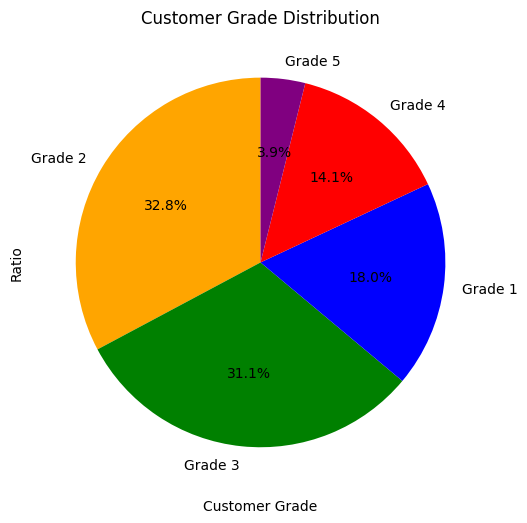

In [112]:
import matplotlib.pyplot as plt

# 각 고객 등급별 고객 수 계산
customer_grade_counts = df2['customer_grade'].value_counts()

# 전체 고객 수 계산
total_customers = customer_grade_counts.sum()

# 각 등급의 비율 계산
customer_grade_ratios = customer_grade_counts / total_customers

# 그래프 그리기
plt.figure(figsize=(8, 6))
customer_grade_ratios.plot(kind='pie', autopct='%1.1f%%', startangle=90, colors=['orange', 'green', 'blue', 'red', 'purple'])
plt.title('Customer Grade Distribution')
plt.xlabel('Customer Grade')
plt.ylabel('Ratio')
plt.xticks(rotation=45)
plt.show()

In [113]:
print(df2['order_date'].min())
print(df2['order_date'].max())


2015-05-19 13:42:09
2016-07-25 01:19:45


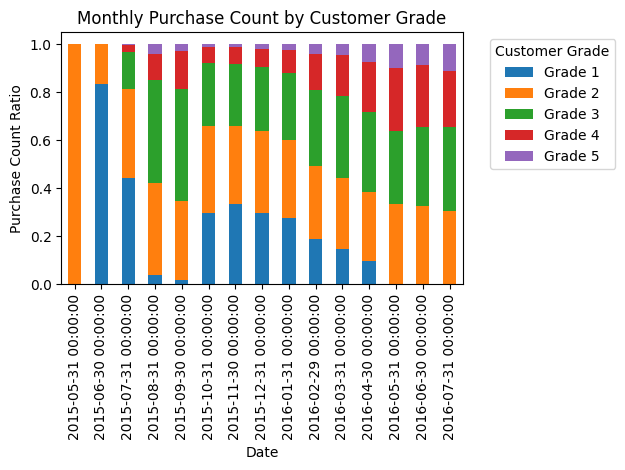

In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 월별로 고객 등급에 따른 구매 비율을 계산합니다.
purchase_count_by_grade_and_date = df2.groupby([pd.Grouper(key='order_date', freq='M'), 'customer_grade']).size().unstack(fill_value=0)

# 비율로 변환합니다.
purchase_count_by_grade_and_date_ratio = purchase_count_by_grade_and_date.div(purchase_count_by_grade_and_date.sum(axis=1), axis=0)

# 시각화하여 나타냅니다.
purchase_count_by_grade_and_date_ratio.plot(kind='bar', stacked=True)
plt.title('Monthly Purchase Count by Customer Grade')
plt.xlabel('Date')
plt.ylabel('Purchase Count Ratio')
#plt.xticks(rotation=45)
plt.legend(title='Customer Grade', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

## NPS 점수와 고객 세그먼트 관련성 분석

In [114]:
# 매 달 구매건수
purchase_counts = []
for month in range(1,13):
    purchase_cnt_month = len(df2[df2['Month'] == month ]['cust_id'])
    purchase_counts.append(purchase_cnt_month)
    
# 결과 출력
for month, count in enumerate(purchase_counts, start=1): 
    print(f'월별 구매건수 (Month {month}): {count}')   

purchase_counts

월별 구매건수 (Month 1): 143768
월별 구매건수 (Month 2): 144084
월별 구매건수 (Month 3): 153299
월별 구매건수 (Month 4): 134390
월별 구매건수 (Month 5): 157072
월별 구매건수 (Month 6): 121798
월별 구매건수 (Month 7): 89285
월별 구매건수 (Month 8): 271
월별 구매건수 (Month 9): 209202
월별 구매건수 (Month 10): 207301
월별 구매건수 (Month 11): 130203
월별 구매건수 (Month 12): 158151


[143768,
 144084,
 153299,
 134390,
 157072,
 121798,
 89285,
 271,
 209202,
 207301,
 130203,
 158151]

In [115]:
purchase_counts_df = pd.DataFrame(purchase_counts, columns=['Purchase Count'], index=range(1, 13))
purchase_counts_df['Month'] = ['2016-1','2016-2','2016-3','2016-4','2016-5','2016-6','2015-7','2015-8','2015-9','2015-10','2015-11','2015-12']
purchase_counts_df['Month'] = pd.to_datetime(purchase_counts_df['Month'])

# 결과 출력
print(purchase_counts_df)

    Purchase Count      Month
1           143768 2016-01-01
2           144084 2016-02-01
3           153299 2016-03-01
4           134390 2016-04-01
5           157072 2016-05-01
6           121798 2016-06-01
7            89285 2015-07-01
8              271 2015-08-01
9           209202 2015-09-01
10          207301 2015-10-01
11          130203 2015-11-01
12          158151 2015-12-01


In [116]:
data = {'NPS' : [54.6,60.0,46.9,44.4,47.0,45.8,47.1,50.3,49.0,51.8,47.3,50.5],
       'Month' : ['2015-7','2015-8','2015-9','2015-10','2015-11','2015-12','2016-1','2016-2','2016-3','2016-4','2016-5','2016-6']}
NPS = pd.DataFrame(data)
NPS['Month'] = pd.to_datetime(NPS['Month'])
NPS

,NPS,Month
0,54.6,2015-07-01
1,60.0,2015-08-01
2,46.9,2015-09-01
3,44.4,2015-10-01
4,47.0,2015-11-01
5,45.8,2015-12-01
6,47.1,2016-01-01
7,50.3,2016-02-01
8,49.0,2016-03-01
9,51.8,2016-04-01


In [117]:
NPS_df = pd.merge(NPS, purchase_counts_df, on='Month', how='inner')  # ID 열을 기준으로 inner join
NPS_df

,NPS,Month,Purchase Count
0,54.6,2015-07-01,89285
1,60.0,2015-08-01,271
2,46.9,2015-09-01,209202
3,44.4,2015-10-01,207301
4,47.0,2015-11-01,130203
5,45.8,2015-12-01,158151
6,47.1,2016-01-01,143768
7,50.3,2016-02-01,144084
8,49.0,2016-03-01,153299
9,51.8,2016-04-01,134390


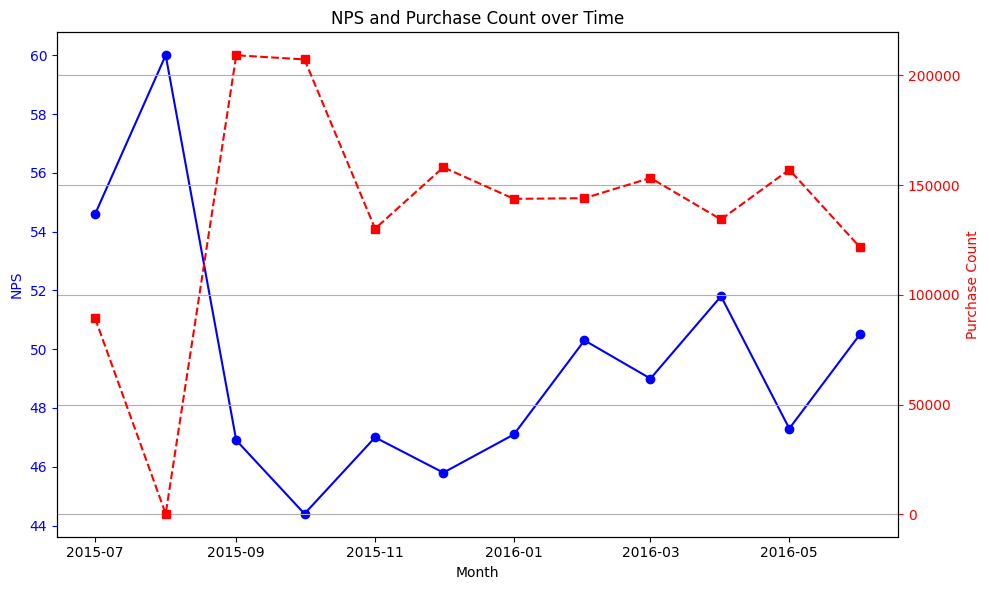

In [46]:
import matplotlib.pyplot as plt


# 이중 축으로 그래프 그리기
fig, ax1 = plt.subplots(figsize=(10, 6))

# 첫 번째 축에 NPS 그래프 그리기
ax1.plot(NPS_df['Month'], NPS_df['NPS'], marker='o', linestyle='-', color='b', label='NPS')
ax1.set_xlabel('Month')
ax1.set_ylabel('NPS', color='b')
ax1.tick_params('y', colors='b')

# 두 번째 축에 구매건수 그래프 그리기
ax2 = ax1.twinx()
ax2.plot(NPS_df['Month'], NPS_df['Purchase Count'], marker='s', linestyle='--', color='r', label='Purchase Count')
ax2.set_ylabel('Purchase Count', color='r')
ax2.tick_params('y', colors='r')



# 그래프 제목 및 범례 추가
plt.title('NPS and Purchase Count over Time')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [118]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [119]:
#df2.drop(columns = ['order_month_x','NPS','order_date_y','order_month_y'], inplace=True)
df2

,fsn_id,order_date,Year,Month,order_id,order_item_id,gmv,units,deliverybdays,deliverycdays,...,product_analytic_vertical,product_mrp,product_procurement_sla,Recency,Frequency,total_gmv,monetary,rfm_score_sum,scaled_rfm_score_sum,customer_grade
0,ACCCX3S58G7B5F6P,2015-10-17 15:11:54,2015,10,3.419301e+15,3.419301e+15,6400.0,1,\N,\N,...,CameraTripod,7190,0,3,1,6400.0,5.0,9.0,0.454545,Grade 3
1,ACCCX3S58G7B5F6P,2015-10-19 10:07:22,2015,10,1.420831e+15,1.420831e+15,6900.0,1,\N,\N,...,CameraTripod,7190,0,3,2,6900.0,5.0,10.0,0.545455,Grade 3
2,ACCCX3S5AHMF55FV,2015-10-20 15:45:56,2015,10,2.421913e+15,2.421913e+15,1990.0,1,\N,\N,...,CameraTripod,2099,3,3,1,1990.0,4.0,8.0,0.363636,Grade 2
3,ACCCX3S5AHMF55FV,2015-10-14 12:05:15,2015,10,4.416592e+15,4.416592e+15,1690.0,1,\N,\N,...,CameraTripod,2099,3,3,2,1690.0,4.0,9.0,0.454545,Grade 3
4,ACCCX3S5AHMF55FV,2015-10-17 21:25:03,2015,10,4.419525e+15,4.419525e+15,1618.0,1,\N,\N,...,CameraTripod,2099,3,3,1,1618.0,4.0,8.0,0.363636,Grade 2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1648819,VPLEYAP3ZYYUVESU,2015-09-27 19:20:31,2015,9,4.402170e+15,4.402170e+15,2200.0,1,\N,\N,...,VideoPlayer,2499,2,3,2,2200.0,5.0,10.0,0.545455,Grade 3
1648820,VPLEYAP3ZYYUVESU,2015-09-28 01:32:58,2015,9,1.402393e+15,1.402393e+15,2098.0,1,\N,\N,...,VideoPlayer,2499,2,3,2,2098.0,5.0,10.0,0.545455,Grade 3
1648821,VPLEYAP3ZYYUVESU,2015-09-29 07:07:57,2015,9,4.403460e+15,4.403460e+15,2098.0,1,\N,\N,...,VideoPlayer,2499,2,3,2,2098.0,5.0,10.0,0.545455,Grade 3
1648822,VPLEYAP3ZYYUVESU,2015-09-29 18:15:45,2015,9,4.403860e+15,4.403860e+15,2200.0,1,\N,\N,...,VideoPlayer,2499,2,3,2,2200.0,5.0,10.0,0.545455,Grade 3


In [120]:
df2['order_month'] = pd.to_datetime(df2['order_date'], format='%Y%m')
df2

,fsn_id,order_date,Year,Month,order_id,order_item_id,gmv,units,deliverybdays,deliverycdays,...,product_mrp,product_procurement_sla,Recency,Frequency,total_gmv,monetary,rfm_score_sum,scaled_rfm_score_sum,customer_grade,order_month
0,ACCCX3S58G7B5F6P,2015-10-17 15:11:54,2015,10,3.419301e+15,3.419301e+15,6400.0,1,\N,\N,...,7190,0,3,1,6400.0,5.0,9.0,0.454545,Grade 3,2015-10-17 15:11:54
1,ACCCX3S58G7B5F6P,2015-10-19 10:07:22,2015,10,1.420831e+15,1.420831e+15,6900.0,1,\N,\N,...,7190,0,3,2,6900.0,5.0,10.0,0.545455,Grade 3,2015-10-19 10:07:22
2,ACCCX3S5AHMF55FV,2015-10-20 15:45:56,2015,10,2.421913e+15,2.421913e+15,1990.0,1,\N,\N,...,2099,3,3,1,1990.0,4.0,8.0,0.363636,Grade 2,2015-10-20 15:45:56
3,ACCCX3S5AHMF55FV,2015-10-14 12:05:15,2015,10,4.416592e+15,4.416592e+15,1690.0,1,\N,\N,...,2099,3,3,2,1690.0,4.0,9.0,0.454545,Grade 3,2015-10-14 12:05:15
4,ACCCX3S5AHMF55FV,2015-10-17 21:25:03,2015,10,4.419525e+15,4.419525e+15,1618.0,1,\N,\N,...,2099,3,3,1,1618.0,4.0,8.0,0.363636,Grade 2,2015-10-17 21:25:03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1648819,VPLEYAP3ZYYUVESU,2015-09-27 19:20:31,2015,9,4.402170e+15,4.402170e+15,2200.0,1,\N,\N,...,2499,2,3,2,2200.0,5.0,10.0,0.545455,Grade 3,2015-09-27 19:20:31
1648820,VPLEYAP3ZYYUVESU,2015-09-28 01:32:58,2015,9,1.402393e+15,1.402393e+15,2098.0,1,\N,\N,...,2499,2,3,2,2098.0,5.0,10.0,0.545455,Grade 3,2015-09-28 01:32:58
1648821,VPLEYAP3ZYYUVESU,2015-09-29 07:07:57,2015,9,4.403460e+15,4.403460e+15,2098.0,1,\N,\N,...,2499,2,3,2,2098.0,5.0,10.0,0.545455,Grade 3,2015-09-29 07:07:57
1648822,VPLEYAP3ZYYUVESU,2015-09-29 18:15:45,2015,9,4.403860e+15,4.403860e+15,2200.0,1,\N,\N,...,2499,2,3,2,2200.0,5.0,10.0,0.545455,Grade 3,2015-09-29 18:15:45


In [121]:
df2['order_month'] = df2['order_month'].dt.to_period('M')

In [122]:
# 월별 세그먼트별 구매 건수 계산
monthly_segment_purchase = df2.groupby(['order_month', 'customer_grade']).size().unstack(fill_value=0)
monthly_segment_purchase

customer_grade,Grade 1,Grade 2,Grade 3,Grade 4,Grade 5
order_month,,,,,
2015-05,0,1,0,0,0
2015-06,5,1,0,0,0
2015-07,39303,32932,13468,2886,94
2015-08,11,103,117,29,11
2015-09,3710,68819,97834,33365,5474
2015-10,61960,74850,54794,13562,2135
2015-11,43342,42801,33627,9179,1254
2015-12,47065,54020,42120,11983,2963
2016-01,39503,47142,40224,13726,3173


In [123]:
# 각 세그먼트별 구매 건수를 전체 구매 건수로 나누어 비율 계산
monthly_segment_purchase_ratio = monthly_segment_purchase.div(monthly_segment_purchase.sum(axis=1), axis=0)

<Figure size 1200x600 with 0 Axes>

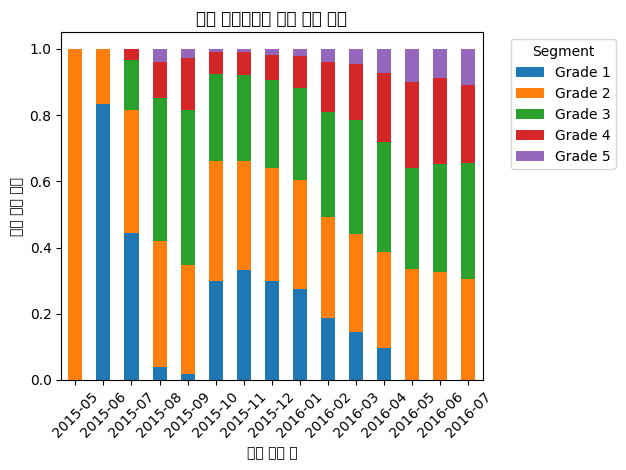

In [53]:
# 시각화
plt.figure(figsize=(12, 6))
monthly_segment_purchase_ratio.plot(kind='bar', stacked=True)
plt.title('월별 세그먼트별 구매 건수 비율')
plt.xlabel('주문 완료 월')
plt.ylabel('구매 건수 비율')
plt.xticks(rotation=45)
plt.legend(title='Segment', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

#### NPS와 고객 세그먼트 상관관계

In [54]:
df3

,index,July'15,Aug'15,Sept'15,Oct'15,Nov'15,Dec'15,Jan'16,Feb'16,Mar'16,Apr'16,May'16,June'16
0,NPS,54.6,60.0,46.9,44.4,47.0,45.8,47.1,50.3,49.0,51.8,47.3,50.5
1,Stock Index,1177.0,1206.0,1101.0,1210.0,1233.0,1038.0,1052.0,1222.0,1015.0,1242.0,1228.0,1194.0


In [55]:
data = {'NPS' : [54.6,60.0,46.9,44.4,47.0,45.8,47.1,50.3,49.0,51.8,47.3,50.5],
       'order_month' : ['201507','201508','201509','201510','201511','201512','201601','201602','201603','201604','201605','201606']}
NPS = pd.DataFrame(data)
NPS['order_month'] = pd.to_datetime(NPS['order_month'], format='%Y%m')

NPS.info()
NPS

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12 entries, 0 to 11
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   NPS          12 non-null     float64       
 1   order_month  12 non-null     datetime64[ns]
dtypes: datetime64[ns](1), float64(1)
memory usage: 320.0 bytes


,NPS,order_month
0,54.6,2015-07-01
1,60.0,2015-08-01
2,46.9,2015-09-01
3,44.4,2015-10-01
4,47.0,2015-11-01
5,45.8,2015-12-01
6,47.1,2016-01-01
7,50.3,2016-02-01
8,49.0,2016-03-01
9,51.8,2016-04-01


In [124]:
segment_kauft = pd.DataFrame(monthly_segment_purchase_ratio)
segment_kauft['NPS'] = [0,0,54.6,60.0,46.9,44.4,47.0,45.8,47.1,50.3,49.0,51.8,47.3,50.5,0]

In [153]:
segment_kauft.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 15 entries, 2015-05 to 2016-07
Freq: M
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Grade 1  15 non-null     float64
 1   Grade 2  15 non-null     float64
 2   Grade 3  15 non-null     float64
 3   Grade 4  15 non-null     float64
 4   Grade 5  15 non-null     float64
 5   NPS      15 non-null     float64
 6   Month    15 non-null     int64  
dtypes: float64(6), int64(1)
memory usage: 960.0 bytes


In [152]:
segment_kauft['Grade 1'] = segment_kauft['Grade 1'].astype(float)
segment_kauft['Grade 2'] = segment_kauft['Grade 2'].astype(float)
segment_kauft['Grade 3'] = segment_kauft['Grade 3'].astype(float)
segment_kauft['Grade 4'] = segment_kauft['Grade 4'].astype(float)
segment_kauft['Grade 5'] = segment_kauft['Grade 5'].astype(float)
segment_kauft['NPS'] = segment_kauft['NPS'].astype(float)

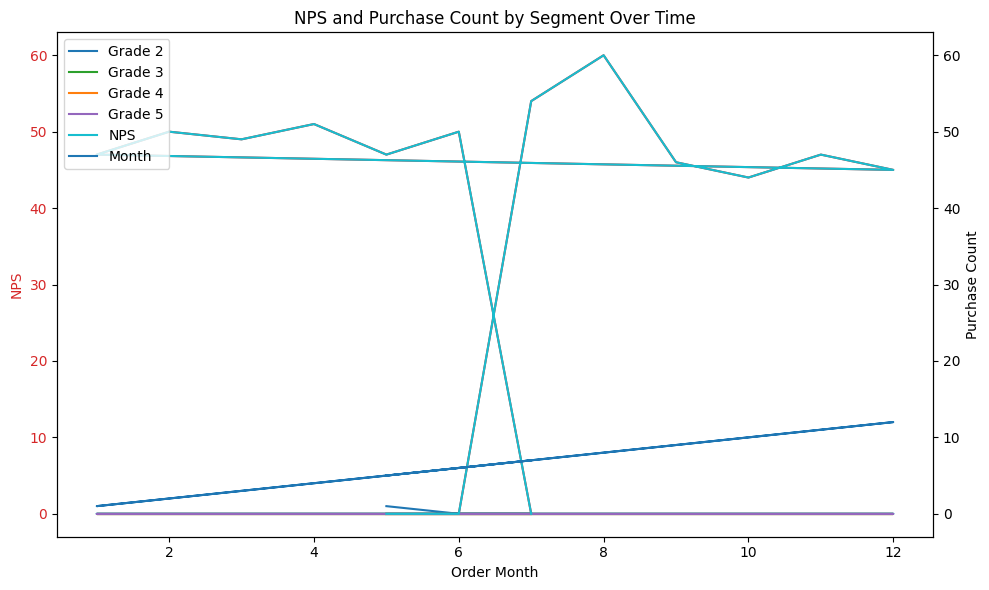

In [154]:
import matplotlib.pyplot as plt

# 월별 숫자로 변환
segment_kauft['Month'] = segment_kauft.index.month

# 시각화 설정
fig, ax1 = plt.subplots(figsize=(10, 6))

# 첫번째 축 (NPS)
color = 'tab:red'
ax1.set_xlabel('Order Month')
ax1.set_ylabel('NPS', color=color)
ax1.plot(segment_kauft['Month'], segment_kauft['NPS'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

# 두번째 축 (세그먼트별 구매건수)
ax2 = ax1.twinx()
colors = ['tab:blue', 'tab:green', 'tab:orange', 'tab:purple', 'tab:cyan']  # 추가 색상
segments = segment_kauft.columns[1:]  # 세그먼트별 구매건수 열 이름
for i, segment in enumerate(segments):
    ax2.plot(segment_kauft['Month'], segment_kauft[segment], label=segment, color=colors[i % len(colors)])  # 인덱스가 범위를 벗어날 경우 다시 처음부터 시작
ax2.set_ylabel('Purchase Count')
ax2.legend(loc='upper left')

# 그래프 제목
plt.title('NPS and Purchase Count by Segment Over Time')

# x축 레이블 회전
plt.xticks(rotation=45)

# 레이아웃 조정 및 그래프 출력
fig.tight_layout()
plt.show()

<Figure size 1000x600 with 0 Axes>

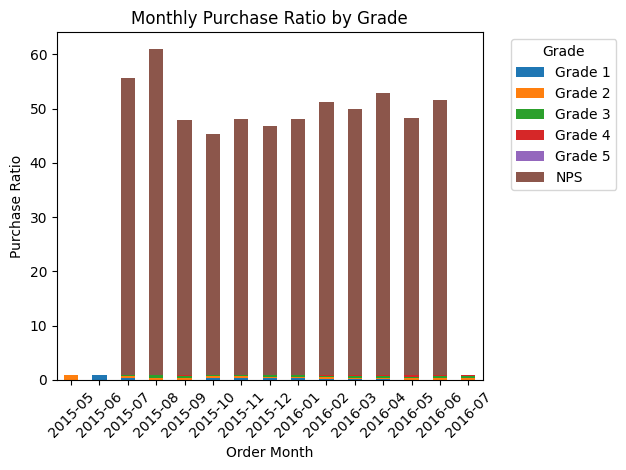

In [127]:
# 시각화
plt.figure(figsize=(10, 6))
segment_kauft.plot(kind='bar', stacked=True)
plt.title('Monthly Purchase Ratio by Grade')
plt.xlabel('Order Month')
plt.ylabel('Purchase Ratio')
plt.xticks(rotation=45)
plt.legend(title='Grade', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

#### 피어슨 상관관계

In [59]:
# 피어슨 상관 계수를 계산합니다
correlation = segment_kauft.corr()

# NPS와 각 Grade 간의 상관 관계를 출력합니다
print(correlation['NPS'])

customer_grade
Grade 1   -0.196352
Grade 2   -0.344821
Grade 3    0.616147
Grade 4    0.274611
Grade 5    0.049943
NPS        1.000000
Name: NPS, dtype: float64


Grade 3 - 0.61으로 중간-강한 양의 상관관계라 나타남

In [60]:
from scipy.stats import pearsonr

# segment_kauft DataFrame의 첫 15개 행과 'NPS' 열 선택
segment_kauft_subset = segment_kauft.iloc[:15]
nps_column = segment_kauft_subset['NPS']

# 피어슨 상관계수와 p-value 계산
corr, p_value = pearsonr(segment_kauft_subset['Grade 3'], nps_column)

print("Pearson correlation coefficient:", corr)
print("p-value:", p_value)

Pearson correlation coefficient: 0.6161465758863753
p-value: 0.014450028694684095


Pearson correlation coefficient: 0.6161465758863753
p-value: 0.014450028694684095

p-value가 0.05보다 낮게 나왔음 -> 유의미한 상관관계

#### grade_3

NPS점수의 유의미한 긍정적인 영향을 준 고객 세그먼트</br>
고객 심층 분석

In [61]:
grade3_df = df2[df2['customer_grade']== 'Grade 3']
grade3_df

,fsn_id,order_date,Year,Month,order_id,order_item_id,gmv,units,deliverybdays,deliverycdays,...,product_mrp,product_procurement_sla,Recency,Frequency,total_gmv,monetary,rfm_score_sum,scaled_rfm_score_sum,customer_grade,order_month
0,ACCCX3S58G7B5F6P,2015-10-17 15:11:54,2015,10,3.419301e+15,3.419301e+15,6400.0,1,\N,\N,...,7190,0,3,1,6400.0,5.0,9.0,0.454545,Grade 3,2015-10
1,ACCCX3S58G7B5F6P,2015-10-19 10:07:22,2015,10,1.420831e+15,1.420831e+15,6900.0,1,\N,\N,...,7190,0,3,2,6900.0,5.0,10.0,0.545455,Grade 3,2015-10
3,ACCCX3S5AHMF55FV,2015-10-14 12:05:15,2015,10,4.416592e+15,4.416592e+15,1690.0,1,\N,\N,...,2099,3,3,2,1690.0,4.0,9.0,0.454545,Grade 3,2015-10
6,ACCCX3S5JGAJETYR,2015-10-16 14:59:57,2015,10,3.418429e+15,3.418429e+15,3695.0,1,\N,\N,...,4044,5,3,1,3695.0,5.0,9.0,0.454545,Grade 3,2015-10
7,ACCCX3S5JGAJETYR,2015-10-15 23:41:39,2015,10,3.417799e+15,3.417799e+15,3695.0,1,\N,\N,...,4044,5,3,1,3695.0,5.0,9.0,0.454545,Grade 3,2015-10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1648819,VPLEYAP3ZYYUVESU,2015-09-27 19:20:31,2015,9,4.402170e+15,4.402170e+15,2200.0,1,\N,\N,...,2499,2,3,2,2200.0,5.0,10.0,0.545455,Grade 3,2015-09
1648820,VPLEYAP3ZYYUVESU,2015-09-28 01:32:58,2015,9,1.402393e+15,1.402393e+15,2098.0,1,\N,\N,...,2499,2,3,2,2098.0,5.0,10.0,0.545455,Grade 3,2015-09
1648821,VPLEYAP3ZYYUVESU,2015-09-29 07:07:57,2015,9,4.403460e+15,4.403460e+15,2098.0,1,\N,\N,...,2499,2,3,2,2098.0,5.0,10.0,0.545455,Grade 3,2015-09
1648822,VPLEYAP3ZYYUVESU,2015-09-29 18:15:45,2015,9,4.403860e+15,4.403860e+15,2200.0,1,\N,\N,...,2499,2,3,2,2200.0,5.0,10.0,0.545455,Grade 3,2015-09


In [62]:
grade3_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 513121 entries, 0 to 1648823
Data columns (total 28 columns):
 #   Column                           Non-Null Count   Dtype         
---  ------                           --------------   -----         
 0   fsn_id                           513121 non-null  object        
 1   order_date                       513121 non-null  datetime64[ns]
 2   Year                             513121 non-null  int64         
 3   Month                            513121 non-null  int64         
 4   order_id                         513121 non-null  float64       
 5   order_item_id                    513121 non-null  float64       
 6   gmv                              508862 non-null  float64       
 7   units                            513121 non-null  int64         
 8   deliverybdays                    513121 non-null  object        
 9   deliverycdays                    513121 non-null  object        
 10  s1_fact.order_payment_type       513121 non-null

#### 세부 분석 내용
* 구매빈도 및 주기분석
* 구매 금액 분석
* 크로스-판매 및 업셀링분석
* 구매유형 분류


##### 구매빈도 및 주기분석

In [63]:
# 평균 구매 빈도
purchase_frequency = grade3_df.groupby('cust_id').size()
average_purchase_frequency = purchase_frequency.mean()
average_purchase_frequency

1.3565836957527528

In [156]:
df2.groupby('cust_id').size().mean()

1.3153813936234289

In [64]:
grade3_df['order_day'] = pd.to_datetime(grade3_df['order_date']).dt.date
grade3_df

,fsn_id,order_date,Year,Month,order_id,order_item_id,gmv,units,deliverybdays,deliverycdays,...,product_procurement_sla,Recency,Frequency,total_gmv,monetary,rfm_score_sum,scaled_rfm_score_sum,customer_grade,order_month,order_day
0,ACCCX3S58G7B5F6P,2015-10-17 15:11:54,2015,10,3.419301e+15,3.419301e+15,6400.0,1,\N,\N,...,0,3,1,6400.0,5.0,9.0,0.454545,Grade 3,2015-10,2015-10-17
1,ACCCX3S58G7B5F6P,2015-10-19 10:07:22,2015,10,1.420831e+15,1.420831e+15,6900.0,1,\N,\N,...,0,3,2,6900.0,5.0,10.0,0.545455,Grade 3,2015-10,2015-10-19
3,ACCCX3S5AHMF55FV,2015-10-14 12:05:15,2015,10,4.416592e+15,4.416592e+15,1690.0,1,\N,\N,...,3,3,2,1690.0,4.0,9.0,0.454545,Grade 3,2015-10,2015-10-14
6,ACCCX3S5JGAJETYR,2015-10-16 14:59:57,2015,10,3.418429e+15,3.418429e+15,3695.0,1,\N,\N,...,5,3,1,3695.0,5.0,9.0,0.454545,Grade 3,2015-10,2015-10-16
7,ACCCX3S5JGAJETYR,2015-10-15 23:41:39,2015,10,3.417799e+15,3.417799e+15,3695.0,1,\N,\N,...,5,3,1,3695.0,5.0,9.0,0.454545,Grade 3,2015-10,2015-10-15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1648819,VPLEYAP3ZYYUVESU,2015-09-27 19:20:31,2015,9,4.402170e+15,4.402170e+15,2200.0,1,\N,\N,...,2,3,2,2200.0,5.0,10.0,0.545455,Grade 3,2015-09,2015-09-27
1648820,VPLEYAP3ZYYUVESU,2015-09-28 01:32:58,2015,9,1.402393e+15,1.402393e+15,2098.0,1,\N,\N,...,2,3,2,2098.0,5.0,10.0,0.545455,Grade 3,2015-09,2015-09-28
1648821,VPLEYAP3ZYYUVESU,2015-09-29 07:07:57,2015,9,4.403460e+15,4.403460e+15,2098.0,1,\N,\N,...,2,3,2,2098.0,5.0,10.0,0.545455,Grade 3,2015-09,2015-09-29
1648822,VPLEYAP3ZYYUVESU,2015-09-29 18:15:45,2015,9,4.403860e+15,4.403860e+15,2200.0,1,\N,\N,...,2,3,2,2200.0,5.0,10.0,0.545455,Grade 3,2015-09,2015-09-29


In [73]:
# 첫구매가 일어난 날
first_purchase_date = grade3_df.groupby('cust_id')['order_day'].min()
purchase_count_by_date = first_purchase_date.value_counts()
purchase_count_by_date.head(10)

order_day
2015-10-16    11303
2016-04-27     9448
2015-10-17     4050
2015-12-21     3462
2016-03-09     3177
2016-03-07     3171
2015-10-15     3081
2015-10-14     2676
2016-03-08     2657
2016-05-25     2652
Name: count, dtype: int64

유독 아래 날짜가 유입이 많았음</br>
2015-10-16  (11303)</br>
2016-04-27  (9448)</br>
프로모션 기간이였나?

In [ ]:
df1
# 2015-10-16/2015-10-17 이 때의 프로모션이 의미가 있었나?

##### 구매금액

In [74]:
total_gmv = df2.groupby('cust_id')['total_gmv'].sum()
grade3_total_gmv = grade3_df.groupby('cust_id')['total_gmv'].sum()
print('total_gmv:', total_gmv.mean())
print('grade3_total_gmv:', grade3_total_gmv.mean())
# 전체 평균 구매 금액보다 grade3등급의 고객들의 평균 구매 금액이 높다

total_gmv: 3378.40647828597
grade3_total_gmv: 5681.618104150032


In [75]:
#각 카테고리별 상품 평균 금액
print(df2.groupby('product_analytic_category')['gmv'].mean())
print(df2.groupby('product_analytic_sub_category')['gmv'].mean())

product_analytic_category
Camera                17641.011526
CameraAccessory        1182.074076
EntertainmentSmall     1373.378091
GameCDDVD              1871.257727
GamingHardware         1973.982002
Name: gmv, dtype: float64
product_analytic_sub_category
AmplifierReceiver       1837.126639
AudioAccessory          1512.968911
AudioMP3Player          1267.987838
Camera                 17641.011526
CameraAccessory         1199.781450
CameraStorage            946.348799
Game                    1872.455422
GameMembershipCards      462.051546
GamingAccessory          850.516259
GamingConsole           9770.124035
HomeAudio               2149.041111
HomeTheatre             5578.083665
Speaker                 1184.081023
TVVideoSmall            1349.708228
Name: gmv, dtype: float64


In [76]:
# 뭘 그렇게 샀을까?
grade3_df.groupby('product_analytic_category')['cust_id'].size()
#EntertainmentSmall에서 유독 많이 구매가 일어남

product_analytic_category
Camera                 63982
CameraAccessory        60388
EntertainmentSmall    293900
GameCDDVD              37595
GamingHardware         57256
Name: cust_id, dtype: int64

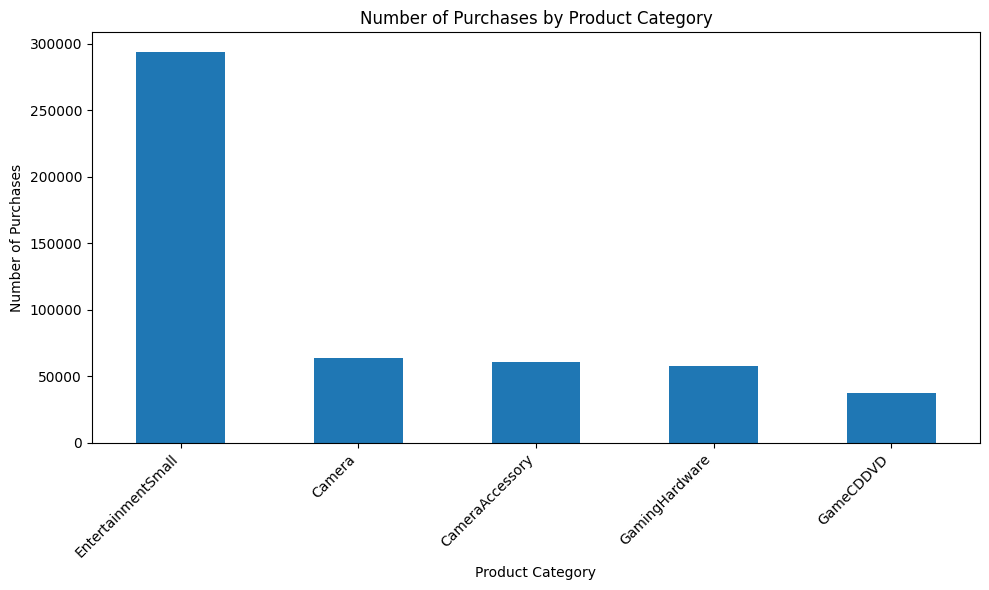

In [129]:
import matplotlib.pyplot as plt

# 데이터 준비
category_counts = grade3_df.groupby('product_analytic_category')['cust_id'].size()
category_counts = category_counts.sort_values(ascending=False)

# 그래프 그리기
plt.figure(figsize=(10, 6))
category_counts.plot(kind='bar')
plt.title('Number of Purchases by Product Category')
plt.xlabel('Product Category')
plt.ylabel('Number of Purchases')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [77]:
# EntertainmentSmall 카테고리의 하부 카테고리 필터링
entertainment_small_subset = grade3_df[grade3_df['product_analytic_category'] == 'EntertainmentSmall']

# 하부 카테고리별 구매량 확인
entertainment_small_sub_category_counts = entertainment_small_subset['product_analytic_sub_category'].value_counts()
print(entertainment_small_sub_category_counts)

product_analytic_sub_category
Speaker              161238
HomeAudio             55029
TVVideoSmall          43075
AudioMP3Player        26499
AudioAccessory         3379
HomeTheatre            2946
AmplifierReceiver      1734
Name: count, dtype: int64


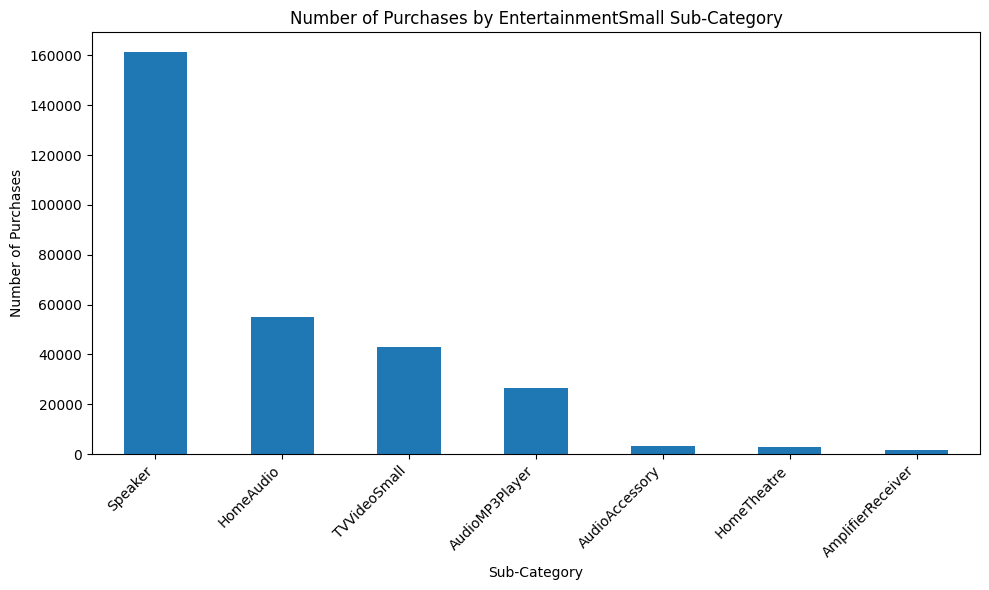

In [130]:
import matplotlib.pyplot as plt

# 데이터 준비
entertainment_small_sub_category_counts = entertainment_small_subset['product_analytic_sub_category'].value_counts()
entertainment_small_sub_category_counts = entertainment_small_sub_category_counts.sort_values(ascending=False)

# 그래프 그리기
plt.figure(figsize=(10, 6))
entertainment_small_sub_category_counts.plot(kind='bar')
plt.title('Number of Purchases by EntertainmentSmall Sub-Category')
plt.xlabel('Sub-Category')
plt.ylabel('Number of Purchases')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [134]:
# product_analytic_sub_category로 더 파고들어가서 분석
grade3_df.groupby('product_analytic_sub_category')['cust_id'].size().sort_values(ascending=False)
#Speaker가 유독 인기 -> grade3등급에서만 인기 있는건지?

product_analytic_sub_category
Speaker                161238
Camera                  63982
CameraAccessory         55335
HomeAudio               55029
GamingAccessory         44595
TVVideoSmall            43075
Game                    37569
AudioMP3Player          26499
GamingConsole           12661
CameraStorage            5053
AudioAccessory           3379
HomeTheatre              2946
AmplifierReceiver        1734
GameMembershipCards        26
Name: cust_id, dtype: int64

In [133]:
#전체 고객중 상품 판매 건수
df2.groupby('product_analytic_sub_category')['cust_id'].size().sort_values(ascending=False)

product_analytic_sub_category
Speaker                543928
CameraAccessory        239508
GamingAccessory        201899
TVVideoSmall           142995
HomeAudio              124860
Game                   114406
AudioMP3Player         112892
Camera                 101172
GamingConsole           29059
CameraStorage           17985
AudioAccessory          11713
HomeTheatre              4254
AmplifierReceiver        4056
GameMembershipCards        97
Name: cust_id, dtype: int64

##### 크로스 판매 업셀링 분석

In [86]:
# # pivot_table() 함수를 사용하여 고객별로 구매한 상품들을 컬럼으로 만듭니다.
# customer_product_df = grade3_df.pivot_table(index='cust_id', columns='product_analytic_vertical', aggfunc=len, fill_value=0)

# # 결과 확인
# print(customer_product_df)

In [80]:
# 고객별로 구매한 상품 목록을 하나의 문자열로 가지고 있는 데이터프레임 생성
customer_product_list_df = grade3_df.groupby('cust_id')['product_analytic_vertical'].apply(lambda x: ','.join(x)).reset_index()

# 문자열을 쉼표로 분리하여 각 상품을 별도의 컬럼으로 만들기
customer_product_list_df = customer_product_list_df.join(customer_product_list_df['product_analytic_vertical'].str.split(',', expand=True).add_prefix('product_'))

# 기존 컬럼 삭제
customer_product_list_df.drop(columns=['product_analytic_vertical'], inplace=True)

# 결과 확인
print(customer_product_list_df)

                      cust_id                product_0              product_1  \
0      -9223350545281059840.0            MobileSpeaker                   None   
1      -9223238858163860480.0             PhysicalGame                   None   
2      -9223193276469189632.0     CameraBatteryCharger                   None   
3      -9223152174345539584.0           AudioMP3Player                   None   
4      -9223141406496430080.0               Binoculars                   None   
...                       ...                      ...                    ...   
378240  9.99696278179181E+017    HandheldGamingConsole  HandheldGamingConsole   
378241  9.99847283716313E+017         HomeAudioSpeaker                   None   
378242  9.99904872060621E+017            MobileSpeaker          MobileSpeaker   
378243  9.99981511652021E+017            LaptopSpeaker          LaptopSpeaker   
378244         91585485558415  CameraStorageMemoryCard         AudioMP3Player   

             product_2 prod

In [81]:
#customer_product_list_df = pd.DataFrame(customer_product_list_df)
customer_product_list_df.drop(columns=['cust_id'], inplace=True)
customer_product_list_df

,product_0,product_1,product_2,product_3,product_4,product_5,product_6,product_7,product_8,product_9,...,product_4249,product_4250,product_4251,product_4252,product_4253,product_4254,product_4255,product_4256,product_4257,product_4258
0,MobileSpeaker,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
1,PhysicalGame,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
2,CameraBatteryCharger,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
3,AudioMP3Player,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
4,Binoculars,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
378240,HandheldGamingConsole,HandheldGamingConsole,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
378241,HomeAudioSpeaker,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
378242,MobileSpeaker,MobileSpeaker,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
378243,LaptopSpeaker,LaptopSpeaker,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None


In [77]:
# 데이터프레임을 CSV 파일로 저장
#customer_product_list_df.to_csv('customer_product_list_df.csv', index=False)

In [85]:
# 각 행에 적용할 함수 정의
def remove_duplicates(row):
    return list(set(row))

# apply 메서드를 사용하여 각 행에 함수 적용
unique_products_df = customer_product_list_df.apply(remove_duplicates, axis=1)

# 결과 확인
print(unique_products_df)

0                                   [MobileSpeaker, None]
1                                    [None, PhysicalGame]
2                            [None, CameraBatteryCharger]
3                                  [AudioMP3Player, None]
4                                      [Binoculars, None]
                               ...                       
378240                      [HandheldGamingConsole, None]
378241                           [None, HomeAudioSpeaker]
378242                              [MobileSpeaker, None]
378243                              [None, LaptopSpeaker]
378244    [AudioMP3Player, CameraStorageMemoryCard, None]
Length: 378245, dtype: object


In [93]:
# 데이터프레임 내의 모든 리스트에서 None 값을 제거하는 함수 정의
def remove_none(lst):
    return [item for item in lst if item is not None]

# apply 메서드를 사용하여 각 행에 적용
cleaned_data = unique_products_df.apply(remove_none)


In [98]:
cleaned_data

0                                   [MobileSpeaker]
1                                    [PhysicalGame]
2                            [CameraBatteryCharger]
3                                  [AudioMP3Player]
4                                      [Binoculars]
                            ...                    
378240                      [HandheldGamingConsole]
378241                           [HomeAudioSpeaker]
378242                              [MobileSpeaker]
378243                              [LaptopSpeaker]
378244    [AudioMP3Player, CameraStorageMemoryCard]
Length: 378245, dtype: object

In [94]:
unique_products_df.info()

<class 'pandas.core.series.Series'>
RangeIndex: 378245 entries, 0 to 378244
Series name: None
Non-Null Count   Dtype 
--------------   ----- 
378245 non-null  object
dtypes: object(1)
memory usage: 2.9+ MB


In [78]:
#!pip install mlxtend

In [95]:
print(unique_products_df.isnull().sum())


0


In [ ]:
customer_product_list_df_filled = unique_products_df.fillna('')

In [87]:
from mlxtend.preprocessing import TransactionEncoder

In [99]:
# 데이터프레임을 리스트의 리스트로 변환
transactions = cleaned_data.values.tolist()

# TransactionEncoder를 사용하여 트랜잭션 인코딩 적용
te = TransactionEncoder()
te_ary = te.fit(transactions).transform(transactions)

# 결과를 데이터프레임으로 변환
te_df = pd.DataFrame(te_ary, columns=te.columns_)

# 결과 확인
print(te_df)

        AmplifierReceiver  AudioMP3Player  Binoculars  BoomBox  Camcorders  \
0                   False           False       False    False       False   
1                   False           False       False    False       False   
2                   False           False       False    False       False   
3                   False            True       False    False       False   
4                   False           False        True    False       False   
...                   ...             ...         ...      ...         ...   
378240              False           False       False    False       False   
378241              False           False       False    False       False   
378242              False           False       False    False       False   
378243              False           False       False    False       False   
378244              False            True       False    False       False   

        CameraAccessory  CameraBag  CameraBattery  CameraBatter

In [100]:
len(te.columns_)

72

In [101]:
# 연관규칙분석을 위한 전처리 완료
te_df

,AmplifierReceiver,AudioMP3Player,Binoculars,BoomBox,Camcorders,CameraAccessory,CameraBag,CameraBattery,CameraBatteryCharger,CameraBatteryGrip,...,SoundMixer,SportsAndAction,Strap,TVOutCableAccessory,Teleconverter,Telescope,VideoGlasses,VideoPlayer,VoiceRecorder,\N
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
3,False,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
378240,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
378241,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
378242,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
378243,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [102]:
# 연관규칙분포 테스트 데이터 다운로드
te_df.to_csv('te_df.csv', index=False)

##### 구매규칙분석
apriori를 사용한 규칙탐색

In [110]:
from mlxtend.frequent_patterns import apriori, association_rules

frequent_itemset = apriori(te_df, min_support=0.003, max_len=3, use_colnames=True)

frequent_itemset['length'] = frequent_itemset['itemsets'].apply(lambda x: len(x))
frequent_itemset.sort_values('support', ascending=False, inplace=True)

In [111]:
frequent_itemset

,support,itemsets,length
26,0.193443,(MobileSpeaker),1
23,0.121731,(LaptopSpeaker),1
21,0.090333,(HomeAudioSpeaker),1
10,0.088345,(DSLR),1
27,0.074930,(PhysicalGame),1
28,0.060926,(Point & Shoot),1
1,0.050224,(AudioMP3Player),1
30,0.044500,(SelectorBox),1
14,0.032878,(GamePad),1
32,0.024571,(VideoPlayer),1


In [112]:
# 2개이상
frequent_itemset[frequent_itemset['length']>=2].head()

,support,itemsets,length
37,0.008341,"(MobileSpeaker, LaptopSpeaker)",2
36,0.003871,"(HomeAudioSpeaker, LaptopSpeaker)",2
35,0.003495,"(CameraBattery, CameraBatteryCharger)",2


In [113]:
##상위에서 생성한 규칙에 대해, 추가 지표에 대한 탐색
# metric과 threshold 설정 필요
association_rules_df = association_rules(frequent_itemset, metric='confidence', min_threshold=0.005)

In [114]:
association_rules_df

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(MobileSpeaker),(LaptopSpeaker),0.193443,0.121731,0.008341,0.043119,0.354219,-0.015207,0.917846,-0.693285
1,(LaptopSpeaker),(MobileSpeaker),0.121731,0.193443,0.008341,0.068521,0.354219,-0.015207,0.865889,-0.674881
2,(HomeAudioSpeaker),(LaptopSpeaker),0.090333,0.121731,0.003871,0.042847,0.351983,-0.007126,0.917585,-0.669298
3,(LaptopSpeaker),(HomeAudioSpeaker),0.121731,0.090333,0.003871,0.031796,0.351983,-0.007126,0.939540,-0.677026
4,(CameraBattery),(CameraBatteryCharger),0.019762,0.009219,0.003495,0.176856,19.184103,0.003313,1.203655,0.966983
5,(CameraBatteryCharger),(CameraBattery),0.009219,0.019762,0.003495,0.379122,19.184103,0.003313,1.578794,0.956693


In [119]:
# 향상도(랜덤적으로 일어나는 현상보다 유의미한 규칙)
rules = association_rules(frequent_itemset, metric='lift', min_threshold=1).sort_values(by=['lift','confidence','support'])
rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(CameraBattery),(CameraBatteryCharger),0.019762,0.009219,0.003495,0.176856,19.184103,0.003313,1.203655,0.966983
1,(CameraBatteryCharger),(CameraBattery),0.009219,0.019762,0.003495,0.379122,19.184103,0.003313,1.578794,0.956693


In [121]:
# 많이 발견되는 규칙 (support)
rules = association_rules(frequent_itemset, metric='support', min_threshold=0.003).sort_values(by=['lift','confidence','support'])
rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
3,(LaptopSpeaker),(HomeAudioSpeaker),0.121731,0.090333,0.003871,0.031796,0.351983,-0.007126,0.939540,-0.677026
2,(HomeAudioSpeaker),(LaptopSpeaker),0.090333,0.121731,0.003871,0.042847,0.351983,-0.007126,0.917585,-0.669298
0,(MobileSpeaker),(LaptopSpeaker),0.193443,0.121731,0.008341,0.043119,0.354219,-0.015207,0.917846,-0.693285
1,(LaptopSpeaker),(MobileSpeaker),0.121731,0.193443,0.008341,0.068521,0.354219,-0.015207,0.865889,-0.674881
4,(CameraBattery),(CameraBatteryCharger),0.019762,0.009219,0.003495,0.176856,19.184103,0.003313,1.203655,0.966983
5,(CameraBatteryCharger),(CameraBattery),0.009219,0.019762,0.003495,0.379122,19.184103,0.003313,1.578794,0.956693


In [123]:
# 무조건 같이 사는 규칙
rules = association_rules(frequent_itemset, metric='confidence', min_threshold=0.03).sort_values(by=['lift','confidence','support'])
rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
3,(LaptopSpeaker),(HomeAudioSpeaker),0.121731,0.090333,0.003871,0.031796,0.351983,-0.007126,0.939540,-0.677026
2,(HomeAudioSpeaker),(LaptopSpeaker),0.090333,0.121731,0.003871,0.042847,0.351983,-0.007126,0.917585,-0.669298
0,(MobileSpeaker),(LaptopSpeaker),0.193443,0.121731,0.008341,0.043119,0.354219,-0.015207,0.917846,-0.693285
1,(LaptopSpeaker),(MobileSpeaker),0.121731,0.193443,0.008341,0.068521,0.354219,-0.015207,0.865889,-0.674881
4,(CameraBattery),(CameraBatteryCharger),0.019762,0.009219,0.003495,0.176856,19.184103,0.003313,1.203655,0.966983
5,(CameraBatteryCharger),(CameraBattery),0.009219,0.019762,0.003495,0.379122,19.184103,0.003313,1.578794,0.956693


### 결론
* 장바구니 연관분석을 진행해본 결과

전자기기 특성상 카메라배터리-충전기 조합으로 많이 구매를 하고</br>
두 종류의 스피커를 같이 사는 것으로 봐서 -> 장비셋팅?목적의 구매가 많았음을 알 수 있음